# Homework 7 Template

Rixin Li & G . Besla



In [272]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [273]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [274]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """
        Class to calculate the analytical orbit of M33 around M31
        Inputs: 
            filename: string
                file that will store integrated orbit
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        self.com33 = CenterOfMass("M33_000.txt", 2)

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        self.com_pos33 = self.com33.COM_P(0.1, 4.0)

        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        self.com_vel33 = self.com33.COM_V(self.com_pos33[0], self.com_pos33[1], self.com_pos33[2]).value
        
        # Get position value
        self.com_pos33 = self.com_pos33.value
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        self.com31 = CenterOfMass("M31_000.txt", 2)

        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        self.com_pos31 = self.com31.COM_P(0.1, 2.0)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.com_vel31 = self.com31.COM_V(self.com_pos31[0],self.com_pos31[1], self.com_pos31[2]).value
        
        # Get position value
        self.com_pos31 = self.com_pos31.value

        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = self.com_pos33 - self.com_pos31
        self.v0 = self.com_vel33 - self.com_vel31       
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.M31DiskMass = ComponentMass("M31_000.txt",2)*1e12

        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.M31BulgeMass = ComponentMass("M31_000.txt",3)*1e12

        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 60
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.M31HaloMass = ComponentMass("M31_000.txt",1)*1e12
    
    
    def HernquistAccel(self, position, mass, r_a): # it is easiest if you take as an input the position VECTOR 
        """ 
        Gravitational acceleration of halo/bulge induced by a Hernquist profile
        Inputs:
            position: tuple
                Vector of the position of galaxy
            mass: float
                Total mass of the bulge or halo
            r_a: float
                Scale length of component
        Outputs:
            Hern: tuple
                Bulge/Halo acceleration vector from Hernquist profile
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.sqrt(position[0]**2 + position[1]**2 + position[2]**2)
        
        ### *** Store the Acceleration
        A = -self.G*mass
        B = rmag*(r_a+rmag)**2
        Hern =  A/B * position
        
        return Hern
    

    
    def MiyamotoNagaiAccel(self, position, mass, rdisk):# it is easiest if you take as an input a position VECTOR  r 
        """ 
        Gravitational acceleration of disk induced by a Miyamoto-Nagai profile
        Inputs:
            position: tuple
                Vector of the position of galaxy
            mass: float
                Mass of the disk
            rdisk: float
                Scale length of the disk
        Output:
            MN75: tuple
                Halo acceleration vector from Miyamoto-Nagai profile
        """
        # Constants
        zd = rdisk/5
        B = rdisk + np.sqrt(position[2]**2 + (zd)**2)
        R = np.sqrt(position[0]**2 + position[1]**2)

        # Simplify
        C = -self.G*mass
        D = R**2 + B**2
        constant = C/D**1.5

        # Components
        ax = constant * position[0]
        ay = constant * position[1]
        az = constant * position[2] * B/(position[2]**2 + zd**2)**0.5

        # Converting to vector
        MN75 = (ax, ay, az)

        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
  
        return MN75
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, position): # input should include the position vector, r
        '''
        Total acceleration of all components of M31
        Inputs:
            position: tuple
                Vector of the position of M31
        Output:
            tot_a: tuple
                Vector of total acceleration of M31
        '''
        a_halo = self.HernquistAccel(position, self.M31HaloMass, self.rhalo)
        a_disk = self.MiyamotoNagaiAccel(position, self.M31DiskMass, self.rdisk)
        a_bulge = self.HernquistAccel(position, self.M31BulgeMass, self.rbulge)
        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
            
        # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        tot_a = a_halo + a_disk + a_bulge

        return tot_a
    
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        '''
        Define acceleration as a function of position
        Inputs:
            dt: float
                Time interval of interest
            r: tuple
                Position vector
            v: tuple
                Velocity vector
        Outputs:
            r_new: tuple
                New position vector
            v_new: tuple
                New velocity vector
        '''
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = r + 1/2*(v + vnew)*dt
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        '''
        Integrate the equations of motion to obtain the orbit
        Inputs:
            t0: float
                Start time
            dt: float
                Time step
            tmax: float
                End time
        Output:
        '''

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt) + 2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)

        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t += dt
           
            # **** store the new time in the first column of the ith row
            orbit[i, 0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            rnew, vnew = self.LeapFrog(dt, orbit[i-1,1:4], orbit[i-1, 4:])
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i, 1] = rnew[0]
            orbit[i, 2] = rnew[1]
            orbit[i, 3] = rnew[2]

            # Velocities
            orbit[i, 4] = vnew[0]
            orbit[i, 5] = vnew[1]
            orbit[i, 6] = vnew[2]
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        
        

In [275]:
# Get analytical orbit
# M33
M33init = M33AnalyticOrbit("M33AnalyticOrbit")
M33Orbit = M33init.OrbitIntegration(0, .0001, 10)

In [276]:
# M33 Info
file = open("M33AnalyticOrbit",'r')
data = np.genfromtxt(file, dtype=None, names=True)
# Net positions and velocities
r_mag_m33 = (data['x']**2 + data['y']**2 + data['z']**2)**(1/2)
v_mag_m33 = (data['vx']**2 + data['vy']**2 + data['vz']**2)**(1/2)

In [277]:
# For simualted orbit
def relative_mag(a, b): 
    """
    Function that computes the magnitude of the difference between two vectors.
    Inputs with shape (3, n) will return n outputs

    PARAMETERS
    ----------
    a : `np.ndarray'
        first vector
    b : 'np.ndarray'
        second vector

    RETURNS
    -------
    mag : `float or np.ndarray`
        |a-b|
    """
    
    # compute the difference vector
    x = a[0] - b[0] 
    y = a[1] - b[1]
    z = a[2] - b[2]

    # return its magnitude
    return np.sqrt(x**2 + y**2 + z**2)

# Get orbit info
M31_orbit = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True) 
M33_orbit = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True) 

# Get position of COM
M31_pos = np.array([M31_orbit['x'], M31_orbit['y'], M31_orbit['z']])
M33_pos = np.array([M33_orbit['x'], M33_orbit['y'], M33_orbit['z']])

# Get relative separation
M33_M31_relpos = relative_mag(M31_pos, M33_pos)

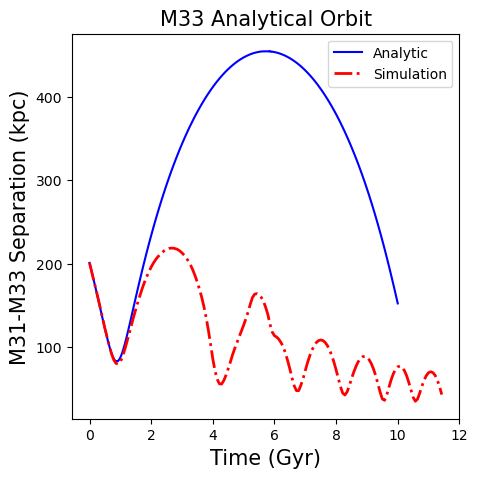

In [281]:
# Plot distance
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

# Plot the separtion of M33 and M31
plt.plot(data['t'], r_mag_m33, c='b', label='Analytic')
plt.plot(M31_orbit['t'], M33_M31_relpos, c='r', lw=2, ls="-.", label='Simulation')

# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=15)
plt.ylabel('M31-M33 Separation (kpc)', fontsize=15)

# Add legend
ax.legend()

# Set title
plt.title("M33 Analytical Orbit", fontsize=15)

plt.show()

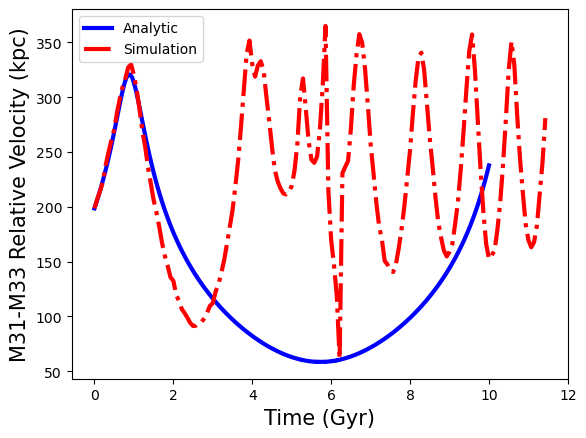

In [279]:
# Velocity Plot

# Get velocity values
M31_vel = np.array([M31_orbit['vx'], M31_orbit['vy'], M31_orbit['vz']])
M33_vel = np.array([M33_orbit['vx'], M33_orbit['vy'], M33_orbit['vz']])

# Get relative velocities
M33_M31_relvel = relative_mag(M31_vel, M33_vel)

# Plot velocities
plt.plot(data['t'], v_mag_m33, c='b', lw=3, label='Analytic')
plt.plot(M31_orbit['t'], M33_M31_relvel, c='r', lw=3, ls="-.", label='Simulation')

# Plot details
plt.xlabel('Time (Gyr)', fontsize=15)
plt.ylabel('M31-M33 Relative Velocity (kpc)', fontsize=15)
plt.legend()
plt.show()

1. Done
2. The graphs agree up until about 1.5 Gyrs in the future. Then the analytic solution takes a wider and slower orbit than the simulation.
3. The analytical solution neglects the dynamical of the galaxies and tidal forces which could affect the tightness of the orbit.
4. The MW could be included by slowly adding mass to M31 over the next 6 Gyrs or, by adding all the MW mass at 6 Gyrs. 
